In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import axes
from matplotlib import font_manager as fm
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from scipy.stats import gaussian_kde
import oddt
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from oddt.scoring import scorer, ensemble_model
from oddt.utils import method_caller
from oddt.scoring.models.regressors import neuralnetwork
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
from sklearn.inspection import permutation_importance
import shap
from collections import defaultdict
import pandas as pd
import numpy as np
import oddt
from oddt import toolkit
from oddt.scoring.descriptors import close_contacts_descriptor, oddt_vina_descriptor

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

## Figure 2

In [4]:
all_pdb=pd.read_csv("../split_dataset/cluster/pdbbind_2020_cluster_result.csv")
cluster_summary=pd.read_csv("../split_dataset/cluster/PCV/PCV_cluster_summary.csv")

In [5]:
labels = cluster_summary[cluster_summary['pdb_num']>300]['cluster'].tolist()
labels.insert(0,"others")
labels = list(reversed(labels))
sizes = cluster_summary[cluster_summary['pdb_num']>300]['pdb_num'].tolist()
others_num = sum(cluster_summary[cluster_summary['pdb_num']<300]['pdb_num'])
sizes.insert(0, others_num)
sizes = list(reversed(sizes))

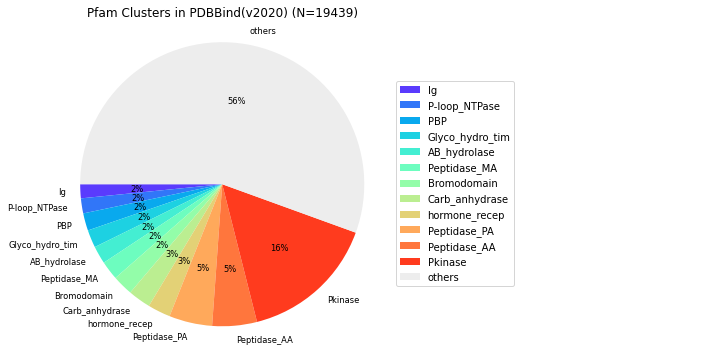

In [6]:
fig, axes = plt.subplots(figsize=(10,5),ncols=2) # 设置绘图区域大小
ax1, ax2 = axes.ravel()

colors = cm.rainbow(np.arange(len(sizes))/len(sizes)) # colormaps: Paired, autumn, rainbow, gray,spring,Darks

grey=np.array([0.75,0.75,0.75,1])
colors=colors[1:]
colors=np.vstack((colors, grey)) 
colors[-1] = [0.93,0.93,0.93,1]
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=180, colors=colors)
ax1.axis('equal')  

proptease = fm.FontProperties()
proptease.set_size('small')
# font size include: ‘xx-small’,x-small’,'small’,'medium’,‘large’,‘x-large’,‘xx-large’ or number, e.g. '12'
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

ax1.set_title('Pfam Clusters in PDBBind(v2020) (N=19439)', loc='center')

# ax2 只显示图例（legend）
ax2.axis('off')
ax2.legend(patches, labels, loc='center left')

plt.tight_layout()
plt.savefig('./png/pfam_cluster_results.png', dpi=800)
# plt.show()

## Figure 3

In [7]:
all_model_average_result = pd.read_csv("../models/results/all_model_3_fold_average.csv")

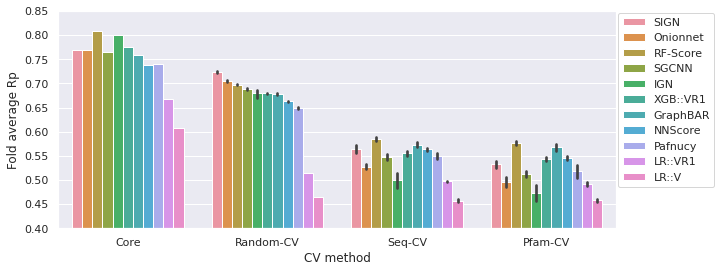

In [6]:
sns.set(font_scale = 1.0)
fig, ax1= plt.subplots(1,1,figsize=(10, 4))
ax1.set_ylim(0.4,0.85)
sns.set_theme(style="whitegrid")
ax1=sns.barplot(x="type", y="average_pearsonr", hue="model", data=all_model_average_result, hue_order = ['SIGN','Onionnet','RF-Score','SGCNN','IGN','XGB::VR1','GraphBAR','NNScore','Pafnucy','LR::VR1','LR::V'], order=['Core','Random-CV', 'Seq-CV', 'Pfam-CV'])
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
# plt.legend()
# plt.legend(loc='upper right', ncol=4)
ax1.set_xlabel("CV method")
ax1.set_ylabel("Fold average Rp")
plt.savefig("./png/overall_rp_no_legend.png", dpi=800, bbox_inches='tight')

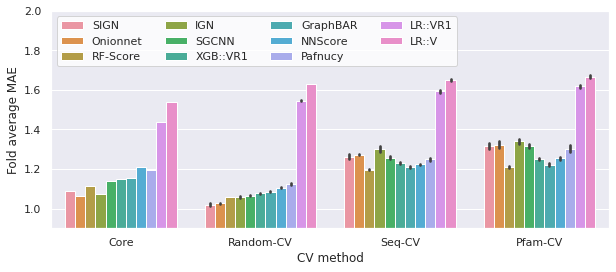

In [63]:
sns.set(font_scale = 1.0)
fig, ax1= plt.subplots(1,1,figsize=(10, 4))
# ax1.set_ylim(0.4,0.85)
ax1.set_ylim(0.9,2.0)
sns.set_theme(style="whitegrid")
ax1=sns.barplot(x="type", y="average_mae", hue="model", data=all_model_average_result, hue_order = ['SIGN','Onionnet','RF-Score','IGN','SGCNN','XGB::VR1','GraphBAR','NNScore','Pafnucy','LR::VR1','LR::V'], order=['Core','Random-CV', 'Seq-CV', 'Pfam-CV'])
# plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
# plt.legend()
plt.legend(loc='upper left', ncol=4)
# plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
ax1.set_xlabel("CV method")
ax1.set_ylabel("Fold average MAE")
plt.savefig("./plot_scripts/png/overall_mae.png", dpi=800, bbox_inches='tight')

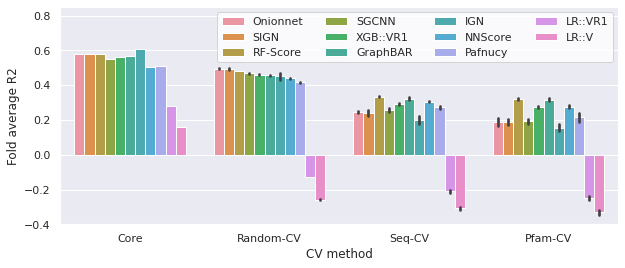

In [68]:
sns.set(font_scale = 1.0)
fig, ax1= plt.subplots(1,1,figsize=(10, 4))
# ax1.set_ylim(0.4,0.85)
ax1.set_ylim(-0.4,0.85)
sns.set_theme(style="whitegrid")
ax1=sns.barplot(x="type", y="average_r2", hue="model", data=all_model_average_result, hue_order = ['Onionnet','SIGN','RF-Score','SGCNN','XGB::VR1','GraphBAR','IGN','NNScore','Pafnucy','LR::VR1','LR::V'], order=['Core','Random-CV', 'Seq-CV', 'Pfam-CV'])
# plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
# plt.legend()
plt.legend(loc='upper right', ncol=4)
# plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
ax1.set_xlabel("CV method")
ax1.set_ylabel("Fold average R2")
plt.savefig("./plot_scripts/png/overall_r2.png", dpi=800, bbox_inches='tight')

## Figure 4
origin scripts:/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/train_test_ligand_similarity.ipynb

In [8]:
selected_cluster=['Alk_phosphatase','Cyclophil-like','POLO_box','Calcineurin','S5']

In [9]:
PCV_clu_score_10 = pd.read_csv("../models/results/RFScore_PCV_10_cluster_rp.csv")
rf_PCV_all_pdb_score=pd.read_csv("../models/results/RFScore_PCV_10_all_pdb_score.csv")
RCV_clu_score_10=pd.read_csv("../models/results/RFScore_RCV_10_cluster_rp.csv")
rf_RCV_all_pdb_score=pd.read_csv("../models/results/RFScore_RCV_10_all_pdb_score.csv")

In [10]:
models =["model_"+str(i) for i in range(1,11)]
PCV_clu_score_10['max'] = PCV_clu_score_10[['cluster']+models].max(axis=1)
PCV_clu_score_10['min'] = PCV_clu_score_10[['cluster']+models].min(axis=1)
PCV_clu_score_10['mean'] = PCV_clu_score_10[['cluster']+models].mean(axis=1)
PCV_clu_score_10['std'] = PCV_clu_score_10[['cluster']+models].std(axis=1)
PCV_clu_score_10['mean_plus_std'] = PCV_clu_score_10['mean']+PCV_clu_score_10['std']
PCV_clu_score_10['mean_minus_std'] = PCV_clu_score_10['mean']-PCV_clu_score_10['std']

In [11]:
# models =["model_"+str(i) for i in range(1,11)]
RCV_clu_score_10['max'] = RCV_clu_score_10[['cluster']+models].max(axis=1)
RCV_clu_score_10['min'] = RCV_clu_score_10[['cluster']+models].min(axis=1)
RCV_clu_score_10['mean'] = RCV_clu_score_10[['cluster']+models].mean(axis=1)
RCV_clu_score_10['std'] = RCV_clu_score_10[['cluster']+models].std(axis=1)
RCV_clu_score_10['mean_plus_std'] = RCV_clu_score_10['mean']+RCV_clu_score_10['std']
RCV_clu_score_10['mean_minus_std'] = RCV_clu_score_10['mean']-RCV_clu_score_10['std']

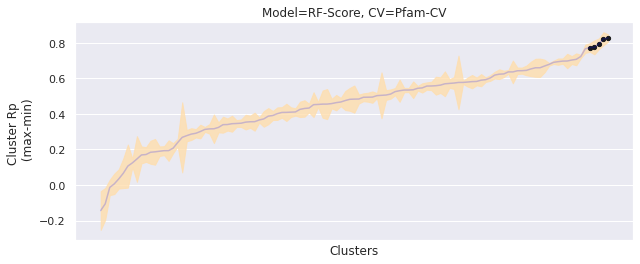

In [19]:
# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(PCV_clu_score_10.sort_values(by=['mean'])['cluster'], PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], PCV_clu_score_10.sort_values(by=['cluster'])['min'], PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(PCV_clu_score_10.sort_values(by=['mean'])['cluster'], PCV_clu_score_10.sort_values(by=['mean'])['mean_minus_std'], PCV_clu_score_10.sort_values(by=['mean'])['mean_plus_std'], color="#FFDEAD", alpha=0.8)
for clu in selected_cluster:
    ax.scatter(PCV_clu_score_10[PCV_clu_score_10['cluster']==clu]['cluster'], PCV_clu_score_10[PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp \n (max-min)")
ax.set_title("Model=RF-Score, CV=Pfam-CV")
# plt.show()
plt.savefig("./png/figure_4_rfscore_pcv.png", dpi=800, bbox_inches='tight')


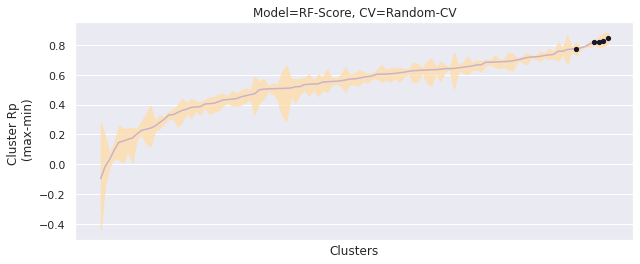

In [20]:
# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(RCV_clu_score_10.sort_values(by=['mean'])['cluster'], RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], RCV_clu_score_10.sort_values(by=['cluster'])['min'], RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(RCV_clu_score_10.sort_values(by=['mean'])['cluster'], RCV_clu_score_10.sort_values(by=['mean'])['min'], RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
for clu in selected_cluster:
    ax.scatter(RCV_clu_score_10[RCV_clu_score_10['cluster']==clu]['cluster'], RCV_clu_score_10[RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp \n (max-min)")
ax.set_title("Model=RF-Score, CV=Random-CV")
# plt.show()
plt.savefig("./png/figure_4_rfscore_rcv.png", dpi=800, bbox_inches='tight')


In [18]:
pafnucy_PCV_clu_score_10=pd.read_csv("../models/results/pafnucy_pcv_10_cluster_rp.csv")
pafnucy_RCV_clu_score_10=pd.read_csv("../models/results/pafnucy_rcv_10_cluster_rp.csv")


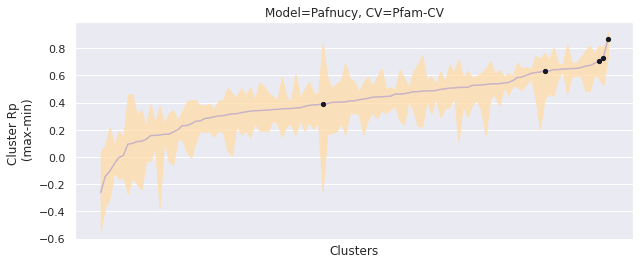

In [21]:
# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['mean'],color="#0000FF", alpha=0.2)
# ax.fill_between(pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['min'], pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['min'], pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
for clu in selected_cluster:
    ax.scatter(clu, pafnucy_PCV_clu_score_10[pafnucy_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp \n (max-min)")
ax.set_title("Model=Pafnucy, CV=Pfam-CV")
# plt.show()
plt.savefig("./png/figure_4_pafnucy_pcv.png", dpi=800, bbox_inches='tight')


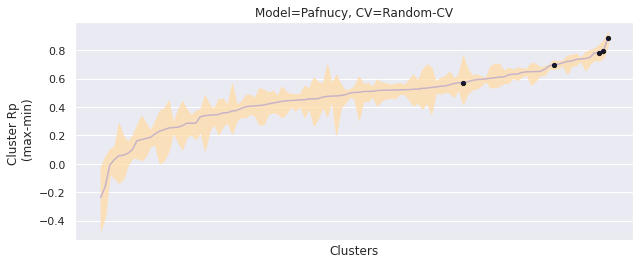

In [22]:
# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['min'], pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['min'], pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
for clu in selected_cluster:
    ax.scatter(clu, pafnucy_RCV_clu_score_10[pafnucy_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp \n (max-min)")
ax.set_title("Model=Pafnucy, CV=Random-CV")
# plt.show()
plt.savefig("./png/figure_4_pafnucy_rcv.png", dpi=800, bbox_inches='tight')


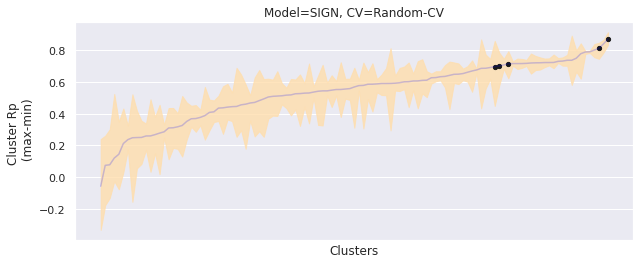

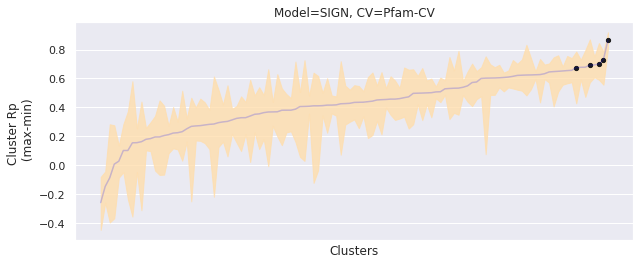

In [23]:
sign_PCV_clu_score_10=pd.read_csv("../models/results/sign_PCV_clu_score_10.csv")
sign_RCV_clu_score_10=pd.read_csv("../models/results/sign_RCV_clu_score_10.csv")

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(sign_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], sign_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(sign_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], sign_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(sign_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], sign_RCV_clu_score_10.sort_values(by=['cluster'])['min'], sign_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(sign_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], sign_RCV_clu_score_10.sort_values(by=['mean'])['min'], sign_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp \n (max-min)")
ax.set_title("Model=SIGN, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, sign_RCV_clu_score_10[sign_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_sign_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(sign_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], sign_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(sign_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], sign_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(sign_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], sign_PCV_clu_score_10.sort_values(by=['cluster'])['min'], sign_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(sign_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], sign_PCV_clu_score_10.sort_values(by=['mean'])['min'], sign_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp \n (max-min)")
ax.set_title("Model=SIGN, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, sign_PCV_clu_score_10[sign_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_sign_pcv.png", dpi=800, bbox_inches='tight')


In [24]:
LR_V_PCV_clu_score_10=pd.read_csv("../models/results/LR_V_PCV_10_cluster_rp.csv")
LR_V_RCV_clu_score_10=pd.read_csv("../models/results/LR_V_RCV_10_cluster_rp.csv")


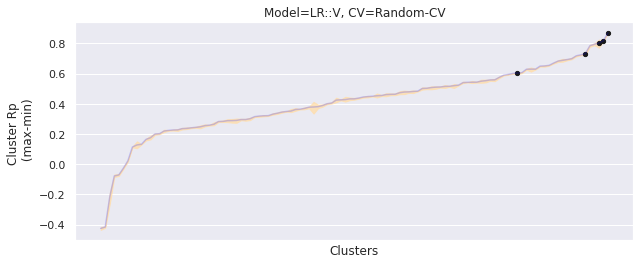

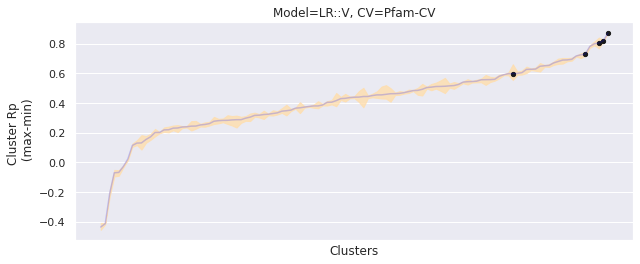

In [25]:

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(LR_V_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_V_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['min'], LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(LR_V_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_V_RCV_clu_score_10.sort_values(by=['mean'])['min'], LR_V_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp \n (max-min)")
ax.set_title("Model=LR::V, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, LR_V_RCV_clu_score_10[LR_V_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_LR_V_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(LR_V_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_V_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['min'], LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(LR_V_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_V_PCV_clu_score_10.sort_values(by=['mean'])['min'], LR_V_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp \n (max-min)")
ax.set_title("Model=LR::V, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, LR_V_PCV_clu_score_10[LR_V_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_LR_V_pcv.png", dpi=800, bbox_inches='tight')


## Figure 5

In [88]:
pcv_rcv_rp = pd.read_csv("../models/results/pcv_rcv_rp_compare_10_times.csv")

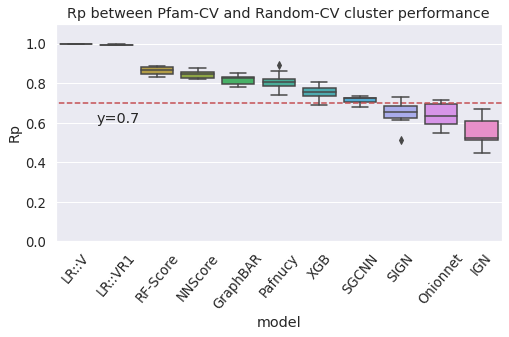

In [92]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(8,4))
plt.hlines(xmin=-1, xmax=13, y=0.7,color="r",linestyles="--", label="y=0.7")
plt.annotate("y=0.7", (0.5,0.6))
sns.boxplot(data=pcv_rcv_rp, x="model",y="rp", order=['LR::V','LR::VR1','RF-Score','NNScore','GraphBAR','Pafnucy','XGB','SGCNN','SIGN','Onionnet','IGN'])
plt.ylim(0,1.1)
plt.title('Rp between Pfam-CV and Random-CV cluster performance')
plt.ylabel('Models')
plt.ylabel("Rp")
for tick in ax.get_xticklabels():
    tick.set_rotation(50)
plt.savefig("./png/figure_5_compare.png", dpi=800, bbox_inches='tight')


In [95]:
RCV_clu_score_10 = RCV_clu_score_10.sort_values(by="cluster")
PCV_clu_score_10 = PCV_clu_score_10.sort_values(by="cluster")

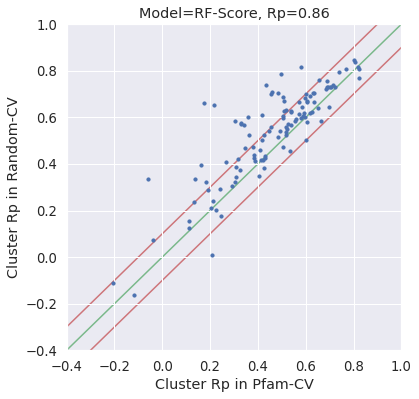

In [107]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
plt.xlim(-0.4,1.0)
plt.ylim(-0.4,1.0)
plt.scatter(PCV_clu_score_10['model_1'], RCV_clu_score_10['model_1'],s=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
lims_up=[lim+0.1 for lim in lims]
lims_down =[lim-0.1 for lim in lims]
ax.plot(lims, lims, 'g', alpha=0.75, zorder=0)
ax.plot(lims, lims_up, 'r', alpha=0.75, zorder=0)
ax.plot(lims, lims_down, 'r', alpha=0.75, zorder=0)
plt.xlabel("Cluster Rp in Pfam-CV")
plt.ylabel("Cluster Rp in Random-CV")
plt.title("Model=RF-Score, Rp=0.86")
plt.savefig("./png/figure_5_rfscore.png", dpi=800, bbox_inches='tight')


In [10]:
LR_V_PCV_clu_score_10=LR_V_PCV_clu_score_10.sort_values(by=['cluster'])
LR_V_RCV_clu_score_10=LR_V_RCV_clu_score_10.sort_values(by=['cluster'])

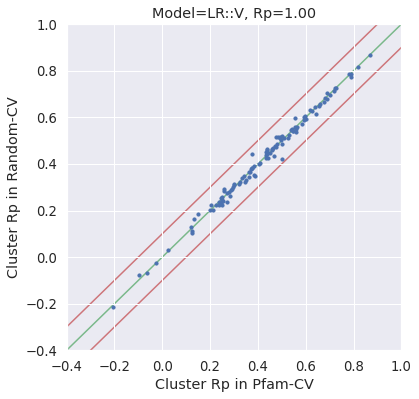

In [11]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
plt.xlim(-0.4,1.0)
plt.ylim(-0.4,1.0)
plt.scatter(LR_V_PCV_clu_score_10['model_1'], LR_V_RCV_clu_score_10['model_1'],s=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
lims_up=[lim+0.1 for lim in lims]
lims_down =[lim-0.1 for lim in lims]
ax.plot(lims, lims, 'g', alpha=0.75, zorder=0)
ax.plot(lims, lims_up, 'r', alpha=0.75, zorder=0)
ax.plot(lims, lims_down, 'r', alpha=0.75, zorder=0)
plt.xlabel("Cluster Rp in Pfam-CV")
plt.ylabel("Cluster Rp in Random-CV")
plt.title("Model=LR::V, Rp=1.00")
plt.savefig("./png/figure_5_lr_v.png", dpi=800, bbox_inches='tight')


## Figure 6
/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/RF_feature_importance.ipynb

## Figure 7

In [4]:
sasa_result_pd = pd.read_csv("../models/results/sasa_correlation_10_repetition.csv")
model_order=['XGB','Onionnet','SGCNN','Pafnucy','IGN','SIGN','GraphBAR','RF-Score','NNScore','LR::VR1','LR::V']

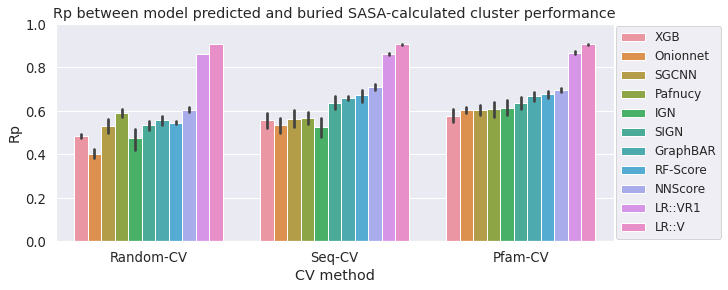

In [14]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(10,4))
sns.barplot(x="cv",y="rp", hue="model", data=sasa_result_pd, order=['Random-CV','Seq-CV','Pfam-CV'], hue_order=model_order)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2, fontsize=12)
# plt.legend()
ax.set_xlabel("CV method")
ax.set_ylabel("Rp")
ax.set_title("Rp between model predicted and buried SASA-calculated cluster performance")
plt.savefig("./png/figure_7_all_model.png", dpi=800, bbox_inches='tight')



In [7]:
single_model=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/eleven_model_cluster_result_selected_cluster.csv")

In [8]:
single_model.head()

,cluster,pdb_num,mw_corre,sasa_corre,rp,mae,r2,model_cv,model,cv
0,Acetyltrans,29,0.301535,0.420929,0.274531,1.161390,-0.326500,IGN_RCV,IGN,RCV
1,Acetyltrans,29,0.301535,0.420929,0.409308,1.106114,-0.019425,IGN_PCV,IGN,PCV
2,Acetyltrans,29,0.301535,0.420929,0.485757,0.940728,0.157210,IGN_SCV,IGN,SCV
3,Acetyltrans,29,0.301535,0.420929,0.537913,1.041775,0.089420,LR::VR1_RCV,LR::VR1,RCV
4,Acetyltrans,29,0.301535,0.420929,0.541192,0.964109,0.152004,LR::VR1_PCV,LR::VR1,PCV


In [17]:
single_model[(single_model['model_cv']=="RFScore_PCV")&(single_model['cluster']=="Periplas_BP")]

,cluster,pdb_num,mw_corre,sasa_corre,rp,mae,r2,model_cv,model,cv
1370,Periplas_BP,62,0.086084,0.115994,0.210846,1.635046,-1.993629,RFScore_PCV,RFScore,PCV


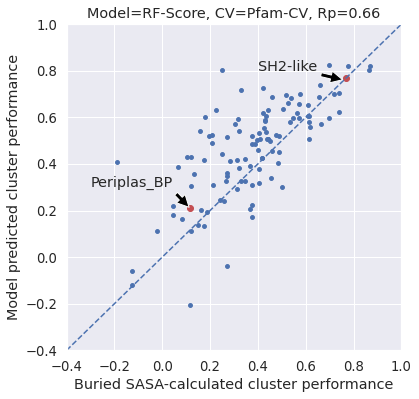

In [23]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
plt.xlim(-0.4,1.0)
plt.ylim(-0.4,1.0)
plt.scatter(single_model[(single_model['model_cv']=="RFScore_PCV")]['sasa_corre'], single_model[(single_model['model_cv']=="RFScore_PCV")]['rp'],s=15)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, linestyle='dashed')
plt.scatter(single_model[(single_model['cluster']=="Periplas_BP")&(single_model['model_cv']=="RFScore_PCV")]['sasa_corre'], single_model[(single_model['cluster']=="Periplas_BP")&(single_model['model_cv']=="RFScore_PCV")]['rp'], color="r")
plt.scatter(single_model[(single_model['cluster']=="SH2-like")&(single_model['model_cv']=="RFScore_PCV")]['sasa_corre'], single_model[(single_model['cluster']=="SH2-like")&(single_model['model_cv']=="RFScore_PCV")]['rp'], color="r")
plt.annotate("SH2-like", xy = (0.76, 0.76), xytext=(0.4,0.8), arrowprops=dict(facecolor="black", shrink=0.05))
plt.annotate("Periplas_BP", xy = (0.116, 0.21), xytext=(-0.3,0.3), arrowprops=dict(facecolor="black", shrink=0.05))
plt.xlabel("Buried SASA-calculated cluster performance")
plt.ylabel("Model predicted cluster performance")
plt.title("Model=RF-Score, CV=Pfam-CV, Rp=0.66")
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_7_rfscore_pcv.png", dpi=800, bbox_inches='tight')


In [2]:
rfscore_all_pdb_score=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/RFScore_PCV_10_all_pdb_score.csv")
all_pdb=pd.read_csv("/pubhome/hzhu02/models/Redocked_pose/split_dataset/cluster/pdbbind_2020_cluster_result.csv")

In [31]:
selected_df = pd.merge(rfscore_all_pdb_score[['pdb','pred_model_1']], all_pdb, on=['pdb'])

In [32]:
sh2=selected_df[selected_df['PCV_cluster']=="SH2-like"]
periplas_bp = selected_df[selected_df['PCV_cluster']=="Periplas_BP"]

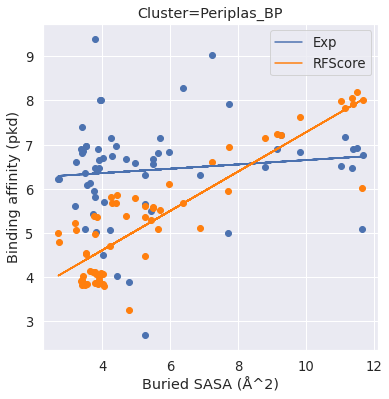

In [57]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
x_sasa = periplas_bp[periplas_bp['delta_sasa']>0]['delta_sasa']
y_exp = periplas_bp[periplas_bp['delta_sasa']>0]['affinity']
y_pred = periplas_bp[periplas_bp['delta_sasa']>0]['pred_model_1']
z_exp = np.polyfit(x_sasa, y_exp, 1)
p_exp = np.poly1d(z_exp)

z_pred=np.polyfit(x_sasa, y_pred, 1)
p_pred = np.poly1d(z_pred)

plt.scatter(x_sasa,y_exp)
plt.plot(x_sasa,p_exp(x_sasa),c="b", label="Exp")

plt.scatter(x_sasa,y_pred, c="#FF7F0E")
plt.plot(x_sasa,p_pred(x_sasa),c="#FF7F0E", label="RFScore")
plt.xlabel("Buried SASA (Å^2)")
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=Periplas_BP")
plt.legend()
# plt.annotate("Exp", xy = (0.76, 0.76), xytext=(8,3), arrowprops=dict(facecolor="black", shrink=0.05))
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_7_periplas_bp.png", dpi=800, bbox_inches='tight')

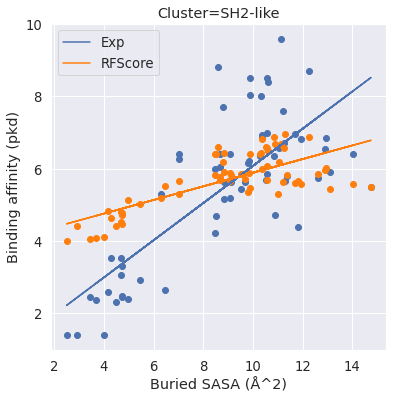

In [58]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
x_sasa = sh2[sh2['delta_sasa']>0]['delta_sasa']
y_exp = sh2[sh2['delta_sasa']>0]['affinity']
y_pred = sh2[sh2['delta_sasa']>0]['pred_model_1']
z_exp = np.polyfit(x_sasa, y_exp, 1)
p_exp = np.poly1d(z_exp)

z_pred=np.polyfit(x_sasa, y_pred, 1)
p_pred = np.poly1d(z_pred)

plt.scatter(x_sasa,y_exp)
plt.plot(x_sasa,p_exp(x_sasa),c="b", label="Exp")

plt.scatter(x_sasa,y_pred, c="#FF7F0E")
plt.plot(x_sasa,p_pred(x_sasa),c="#FF7F0E", label="RFScore")
plt.xlabel("Buried SASA (Å^2)")
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=SH2-like")
plt.legend()
# plt.annotate("Exp", xy = (0.76, 0.76), xytext=(8,3), arrowprops=dict(facecolor="black", shrink=0.05))
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_7_sh2.png", dpi=800, bbox_inches='tight')

In [26]:
features = pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/datasets/descriptors/refine_general_features.csv")
vina_title =['vina_gauss1_x',
            'vina_gauss2_x',
            'vina_repulsion_x',
            'vina_hydrophobic_x',
            'vina_hydrogen_x',
            'vina_num_rotors']
rf_v1_title = features.columns.tolist()[2:38]

feature_list = vina_title+rf_v1_title

In [27]:
all_pdb_feature = pd.merge(all_pdb, features, on=['pdb','affinity'])
all_pdb_feature=all_pdb_feature[(all_pdb_feature['mol_weight']<1000)&(all_pdb_feature['delta_sasa']>0)]

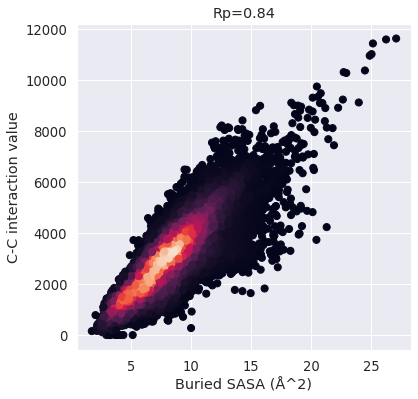

In [5]:
# shap_rotors = [RCV_training_1_shap_values[i][26,26] for i in range(12049)]
plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
x = np.array(all_pdb_feature['delta_sasa'], dtype=float)
y = all_pdb_feature['6.6'].to_list()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# fig, ax = plt.subplots(figsize=())
plt.scatter(x, y, c=z, s=50)
# ax.plot(x, x)
plt.xlabel("Buried SASA (Å^2)")
plt.ylabel("C-C interaction value")
# plt.savefig(path)
plt.title("Rp=0.84")
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_7_sasa_6_6.png", dpi=800, bbox_inches='tight')
# plt.show()

## Figure 8

In [11]:
pearsonr(all_pdb[(all_pdb['delta_sasa']>0)]['affinity'],all_pdb[(all_pdb['delta_sasa']>0)]['delta_sasa'])

(0.26182346638904896, 1.0321312684668437e-300)

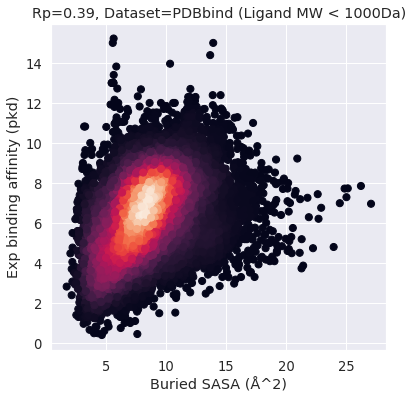

In [68]:
plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
x = np.array(all_pdb_feature['delta_sasa'], dtype=float)
y = all_pdb_feature['affinity'].to_list()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# fig, ax = plt.subplots(figsize=())
plt.scatter(x, y, c=z, s=50)
# ax.plot(x, x)
plt.xlabel("Buried SASA (Å^2)")
plt.ylabel("Exp binding affinity (pkd)")
# plt.savefig(path)
plt.title("Rp=0.39, Dataset=PDBbind (Ligand MW < 1000Da)")
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_sasa_exp_mw_restrain.png", dpi=800, bbox_inches='tight')

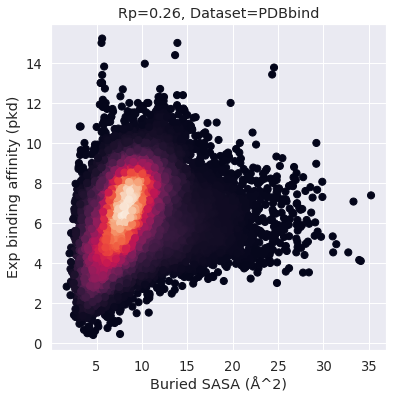

In [69]:
plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
x = np.array(all_pdb[all_pdb['delta_sasa']>0]['delta_sasa'], dtype=float)
y = all_pdb[all_pdb['delta_sasa']>0]['affinity'].to_list()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# fig, ax = plt.subplots(figsize=())
plt.scatter(x, y, c=z, s=50)
# ax.plot(x, x)
plt.xlabel("Buried SASA (Å^2)")
plt.ylabel("Exp binding affinity (pkd)")
# plt.savefig(path)
plt.title("Rp=0.26, Dataset=PDBbind")
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_sasa_exp_no_mw_restrain.png", dpi=800, bbox_inches='tight')

In [12]:
sasa_cor = pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/eleven_model_cluster_result_selected_cluster.csv")
clean_sasa = sasa_cor[['cluster', 'pdb_num','mw_corre','sasa_corre']].drop_duplicates()


In [76]:
clean_sasa[clean_sasa['cluster']=="SH2-like"]

,cluster,pdb_num,mw_corre,sasa_corre
150,SH2-like,65,0.779265,0.766625


In [77]:
clean_sasa[clean_sasa['cluster']=="Calcineurin"]

,cluster,pdb_num,mw_corre,sasa_corre
126,Calcineurin,21,0.808921,0.868314


In [78]:
clean_sasa[clean_sasa['cluster']=="Cyclophil-like"]

,cluster,pdb_num,mw_corre,sasa_corre
342,Cyclophil-like,34,0.739676,0.866085


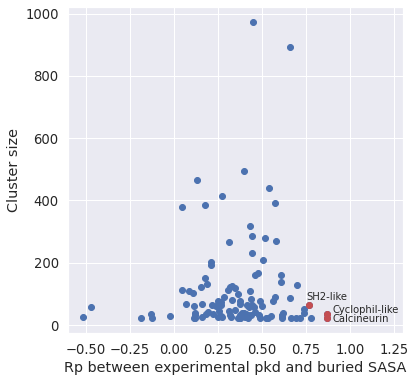

In [85]:

plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
plt.scatter(clean_sasa[clean_sasa['pdb_num']<1000]['sasa_corre'], clean_sasa[clean_sasa['pdb_num']<1000]['pdb_num'])
plt.scatter(clean_sasa[clean_sasa['cluster']=="SH2-like"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="SH2-like"]['pdb_num'], color="r")
plt.scatter(clean_sasa[clean_sasa['cluster']=="Calcineurin"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Calcineurin"]['pdb_num'], color="r")

plt.scatter(clean_sasa[clean_sasa['cluster']=="Cyclophil-like"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Cyclophil-like"]['pdb_num'], color="r")

# plt.scatter(clean_sasa[clean_sasa['cluster']=="Avidin"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Avidin"]['pdb_num'], color="r")
# plt.scatter(clean_sasa[clean_sasa['cluster']=="Sialidase"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Sialidase"]['pdb_num'], color="r")
# plt.scatter(clean_sasa[clean_sasa['cluster']=="Peptidase_AA"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Peptidase_AA"]['pdb_num'], color="r")
plt.annotate("SH2-like", xy=(0.75,80), fontsize=10)
plt.annotate("Cyclophil-like", xy=(0.9,40), fontsize=10)
plt.annotate("Calcineurin", xy=(0.9, 10), fontsize=10)
plt.xlim(-0.6,1.3)
plt.xlabel('Rp between experimental pkd and buried SASA')
plt.ylabel('Cluster size')

plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_cluster.png", dpi=800, bbox_inches='tight')


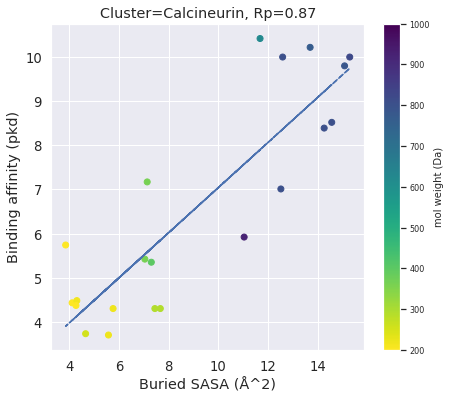

In [6]:

plt.figure(figsize=(7, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
cm = plt.cm.get_cmap('viridis_r')
z_exp = np.polyfit(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Calcineurin")]['delta_sasa'],  all_pdb_feature[all_pdb_feature['PCV_cluster']=="Calcineurin"]['affinity'], 1)
p_exp = np.poly1d(z_exp)
x_sasa=all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Calcineurin")]['delta_sasa']
plt.plot(x_sasa,p_exp(x_sasa),c="b", label="Exp",linestyle="dashed")
# ax.plot(lims, lims, linestyle='dashed')
sc=plt.scatter(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Calcineurin")]['delta_sasa'], all_pdb_feature[all_pdb_feature['PCV_cluster']=="Calcineurin"]['affinity'], c=all_pdb_feature[all_pdb_feature['PCV_cluster']=="Calcineurin"]['mol_weight'], vmin=200, vmax=1000, cmap=cm)
plt.xlabel("Buried SASA (Å^2)")
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=Calcineurin, Rp=0.87")
# plt.colorbar(sc)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('mol weight (Da)', rotation=-270, fontsize=10)

plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_calcineurin.png", dpi=800, bbox_inches='tight')


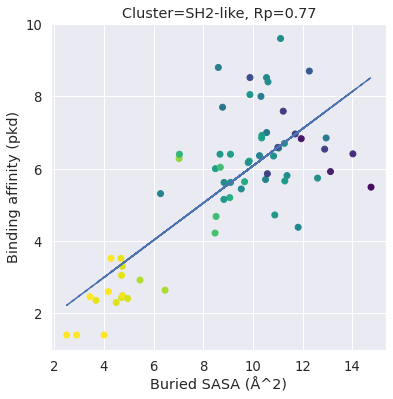

In [7]:

plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
cm = plt.cm.get_cmap('viridis_r')
z_exp = np.polyfit(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="SH2-like")]['delta_sasa'],  all_pdb_feature[all_pdb_feature['PCV_cluster']=="SH2-like"]['affinity'], 1)
p_exp = np.poly1d(z_exp)
x_sasa=all_pdb_feature[(all_pdb_feature['PCV_cluster']=="SH2-like")]['delta_sasa']
plt.plot(x_sasa,p_exp(x_sasa),c="b", label="Exp",linestyle="dashed")
# ax.plot(lims, lims, linestyle='dashed')
sc=plt.scatter(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="SH2-like")]['delta_sasa'], all_pdb_feature[all_pdb_feature['PCV_cluster']=="SH2-like"]['affinity'], c=all_pdb_feature[all_pdb_feature['PCV_cluster']=="SH2-like"]['mol_weight'], vmin=200, vmax=1000, cmap=cm)
plt.xlabel("Buried SASA (Å^2)")
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=SH2-like, Rp=0.77")
# plt.colorbar(sc)
# cbar = plt.colorbar(sc)
# cbar.ax.tick_params(labelsize=8)
# cbar.set_label('mol weight (Da)', rotation=-270, fontsize=10)

plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_SH2-like.png", dpi=800, bbox_inches='tight')


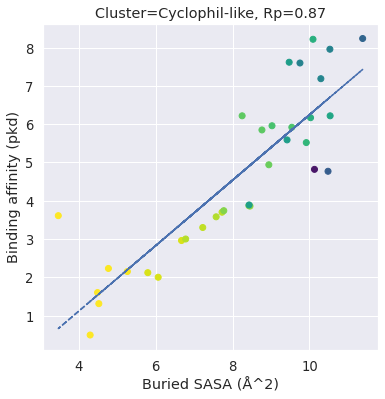

In [8]:

plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
cm = plt.cm.get_cmap('viridis_r')
z_exp = np.polyfit(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Cyclophil-like")]['delta_sasa'],  all_pdb_feature[all_pdb_feature['PCV_cluster']=="Cyclophil-like"]['affinity'], 1)
p_exp = np.poly1d(z_exp)
x_sasa=all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Cyclophil-like")]['delta_sasa']
plt.plot(x_sasa,p_exp(x_sasa),c="b", label="Exp",linestyle="dashed")
# ax.plot(lims, lims, linestyle='dashed')
sc=plt.scatter(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Cyclophil-like")]['delta_sasa'], all_pdb_feature[all_pdb_feature['PCV_cluster']=="Cyclophil-like"]['affinity'], c=all_pdb_feature[all_pdb_feature['PCV_cluster']=="Cyclophil-like"]['mol_weight'], vmin=200, vmax=1000, cmap=cm)
plt.xlabel("Buried SASA (Å^2)")
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=Cyclophil-like, Rp=0.87")
# plt.colorbar(sc)
# cbar = plt.colorbar(sc)
# cbar.ax.tick_params(labelsize=8)
# cbar.set_label('mol weight (Da)', rotation=-270, fontsize=10)

plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_Cyclophil-like.png", dpi=800, bbox_inches='tight')


## OTHERS

In [28]:
all_pdb_feature.head()

,pdb,affinity,PCV_cluster,main_chain,res_num,pfam,pfam_name,pdb_start,pdb_end,cov_num,...,as_flex_backbone_other,as_flex_sidechain_alpha,as_flex_sidechain_beta,as_flex_sidechain_other,as_flex_all,salt_bridge_5.5_alpha,salt_bridge_5.5_beta,salt_bridge_5.5_other,salt_bridge_5.5_all,num_rotors
0,4i7p,3.50,Lysozyme,A,39.0,PF00959,Phage_lysozyme,24.0,148.0,37.0,...,0.0,0.0,0.0,28.0,28.0,0.0,0.0,0.0,0.0,0.0
1,1l83,3.40,Lysozyme,A,39.0,PF00959,Phage_lysozyme,24.0,148.0,37.0,...,0.0,0.0,0.0,18.0,18.0,0.0,0.0,0.0,0.0,0.0
2,1li6,3.80,Lysozyme,A,36.0,PF00959,Phage_lysozyme,24.0,148.0,34.0,...,0.0,0.0,0.0,23.0,23.0,0.0,0.0,0.0,0.0,1.0
3,4w52,3.76,Lysozyme,A,38.0,PF00959,Phage_lysozyme,24.0,148.0,36.0,...,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0
4,188l,3.33,Lysozyme,A,42.0,PF00959,Phage_lysozyme,24.0,148.0,40.0,...,0.0,0.0,0.0,17.0,17.0,0.0,0.0,0.0,0.0,2.0


In [29]:
pearsonr(all_pdb_feature['mol_weight'], all_pdb_feature['6.6'])

(0.6299384296645161, 0.0)